In [3]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from collections import Counter
import yaml
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:

# meters per hour
gen2speed = {"car": 48300,
             "pedbike": 16100,
             "bus": 48300,
             "other": 16100}
# https://nacto.org/publication/transit-street-design-guide/introduction/why/designing-move-people/
gen2capacity = {"car": 1100,
                "pedbike": 8000,
                "bus": 6000,
                "other": 5000}

gen2color_nodes = {"sleep": "orange",
                   "work": "blue",
                   "social": "purple",
                   "other": "gray"}

gen2color_edges = {"car": "red",
                   "pedbike": "green",
                   "bus": "yellow",
                   "other": "gray"}

gen2idx_nodes = {'sleep': 0, 'work': 1, 'social': 2, 
                 'street': 3, 'other': 4}

gen2idx_edges = {'car': 0, 'bus': 1, 'pedbike': 2, 'other': 3}

maps = {"speed": gen2speed, 
        "capacity": gen2capacity,
        "node_colors": gen2color_nodes,
        "edge_colors": gen2color_edges,
        "gen_idx_nodes": gen2idx_nodes,
        "gen_idx_edges": gen2idx_edges}

yaml_paths = {"building": "yaml/building.yaml",
         "highway": "yaml/highway.yaml"}

In [5]:
class graphGenerator:
    # ? add trains?
    def __init__(self, lat: float, lon: float, radius: int, tolerance: int, 
                 yaml_paths: dict, osm_filepath: str, maps: dict) -> None:
        # setup variables for later ref
        self.coords = (float(lat), float(lon))
        self.radius = int(radius)
        self.tolerance = int(tolerance)
        self.building_filepath, self.highway_filepath = (str(yaml_paths["building"]), 
                                                        str(yaml_paths["highway"]))
        self.osm_filepath = str(osm_filepath)
        self.speed_map, self.capacity_map = dict(maps["speed"]), dict(maps["capacity"])
        self.node_colors, self.edge_colors = dict(maps["node_colors"]), dict(maps["edge_colors"])
        self.gen_node_map, self.gen_edge_map = dict(maps["gen_idx_nodes"]), dict(maps["gen_idx_edges"])
        # download and get dfs
        self.G = self.download_network()
        self.nodes, self.edges = self.get_nodes_edges_from_graph()
        # add buildings and collapse nodes to simplify graph
        all_nodes = self.add_buildings()
        self.simplify_network()
        # get majority type from collapsed nodes and add other attrs
        self.set_building_type(all_nodes)
        self.add_node_edge_attrs()
        # encode general attrs and save graph
        self.clean_graph_attrs()
        self.make_categorical()
        self.save_graph2osm()
        # make sure graph looks right
        self.check_osm()
    
    def download_network(self):
        return ox.graph_from_point(self.coords, 
                                dist=self.radius,
                                network_type="all",
                                retain_all=True,
                                simplify=False
                                )
    
    def get_nodes_edges_from_graph(self):
        return ox.graph_to_gdfs(self.G, nodes=True, edges=True)
    
    def plot_graph(self):
        G_inter = ox.graph_from_gdfs(self.nodes, self.edges)
        G_inter = ox.project_graph(self.G)
        fig, ax = ox.plot_graph(G_inter, node_size=10)
    
    def add_buildings(self):
        # TODO: make tags hyperparam 
        tags = {"building": True} 
        buildings = ox.features_from_point(self.coords, tags, 
                                           dist=self.radius)

        centroids = buildings.centroid
        building_list = []
        edge_list = []
        
        # iterate over buildings
        for i, c in enumerate(centroids):
            # create node list
            building_list.append({'geometry': Point(c.x, c.y),
                                'osmid': i,
                                'y': c.y,
                                'x': c.x,
                                'building': buildings.iloc[i]['building'],
                                })
            # find closest preexisting node in G
            proxy_node_id, dist = ox.distance.nearest_nodes(self.G, c.x, c.y, return_dist=True)
            proxy_node = self.nodes.loc[proxy_node_id]
            
            # create edge list of building node to proxy node
            edge_list.append({'geometry': LineString([(c.x, c.y), (proxy_node.x, proxy_node.y)]),
                            'osmid': 2000000+i,                  # TODO: find max value to make adaptable
                            'highway': 'residential',
                            'oneway': False,
                            'length': dist,
                            'lanes': 1,
                            'u': i,
                            'v': proxy_node_id,
                            'key': 0,
                            })
        
        # Turn into dfs and set compatible indexes
        my_nodes = gpd.GeoDataFrame(building_list)
        my_nodes.set_index('osmid', inplace=True)

        my_edges = gpd.GeoDataFrame(edge_list)
        my_edges.set_index(['u', 'v', 'key'], inplace=True)

        # TODO: use street count to augment capacity
        # transform street_count to building, drop highway
        self.nodes['building'] = 'street'
        if 'highway' in self.nodes.columns:
            self.nodes = self.nodes.drop(['street_count', 'highway'], axis=1)

        # Combine building and intersection nodes; Combine edges
        all_nodes = pd.concat([self.nodes, my_nodes])
        all_edges = pd.concat([self.edges, my_edges])

        # Simplify edges and nodes
        all_nodes = all_nodes[['building', 'x', 'y', 'geometry']]
        all_edges = all_edges[['osmid', 'highway', 'length', 'geometry']]
        
        # Make graph
        self.G = ox.graph_from_gdfs(all_nodes, all_edges)
        return all_nodes
            
    def simplify_network(self):
        # collapse nodes within tolerance
        G_temp = ox.project_graph(self.G)
        G_temp = ox.consolidate_intersections(G_temp, rebuild_graph=True, reconnect_edges=True, 
                                            dead_ends=True, tolerance=self.tolerance)
        # remove islands
        self.G = ox.utils_graph.get_largest_component(G_temp)
        # refresh node and edge values
        self.nodes, self.edges = self.get_nodes_edges_from_graph()
    
    def set_building_type(self, all_nodes):
        # set building type according to majority vote
        for i, r in self.nodes.iterrows():
            if type(r['osmid_original']) == str:
                osmid_list = [int(i) for i in r['osmid_original'][1:-1].split(", ")]

                counts = {}
                for n in osmid_list:
                    build_type = all_nodes.loc[n, 'building']
                    if build_type in counts:
                        counts[build_type] = counts[build_type] + 1
                    else:
                        counts[build_type] = 1
                
                if len(counts.keys()) == 1 and 'yes' in counts:
                    print('yes only node type in cluster')
                    self.nodes.loc[i, 'building'] = 'street'
                else:
                    if 'yes' in counts.keys():  
                        del counts['yes']
                    maj_vote = max(counts.items(), key=lambda x: x[1])[0]
                    self.nodes.loc[i, 'building'] = maj_vote
    
    def read_yaml(self):
        # read building and highway OSM saved as yaml
        with open(self.building_filepath, 'r') as f:
            building_yaml = yaml.safe_load(f)

        with open(self.highway_filepath, 'r') as f:
            highway_yaml = yaml.safe_load(f)
        
        return building_yaml, highway_yaml

    def add_node_edge_attrs(self):
        building_yaml, highway_yaml = self.read_yaml()
        
        # Add node building attributes
        for i, r in self.nodes.iterrows():
            building = self.nodes.loc[i, 'building']
            
            if building in building_yaml.keys():
                general = building_yaml[building]['general']
                color = self.node_colors[general]
            else:
                general, color = 'street', 'gray'
            self.nodes.loc[i, 'general'] = general
            self.nodes.loc[i, 'color'] = color
        self.nodes['idx'] = self.nodes.index

        # Add edge street attributes
        for i, r in self.edges.iterrows():
            highway = self.edges.loc[i, 'highway']
            if highway in highway_yaml.keys():
                general = highway_yaml[highway]['general']
                color = self.edge_colors[general]
            else:
                general, color = 'street', 'gray'
            speed = self.speed_map[general]
            capacity = self.capacity_map[general]
            self.edges.loc[i, 'general'] = general
            self.edges.loc[i, 'color'] = color
            self.edges.loc[i, 'speed'] = speed
            self.edges.loc[i, 'capacity'] = capacity
        edge_idx = self.edges.index.to_frame(name=['u', 'v', 'key'])
        edge_idx = edge_idx.drop('key', axis=1)
        self.edges = pd.concat([self.edges, edge_idx], axis=1)
    
    def clean_graph_attrs(self):
        # Simplify edges and nodes
        self.nodes = self.nodes[['idx', 'building', 'general', 'color', 
                                 'x', 'y', 'geometry']]
        self.edges = self.edges[['u', 'v', 'osmid', 'highway', 'general', 'color', 
                                 'length', 'speed', 'capacity', 'geometry']]

        # refresh graph
        self.G = ox.graph_from_gdfs(self.nodes, self.edges)
        
    def make_categorical(self):
        # convert str attrs to categorical attrs
        for i, r in self.nodes.iterrows():
            for n_type, idx in self.gen_node_map.items():
                if r["general"] == n_type:
                    self.nodes.loc[i, f"general{idx}"] = 1
                else:
                    self.nodes.loc[i, f"general{idx}"] = 0
        
        for i, r in self.edges.iterrows():
            for n_type, idx in self.gen_edge_map.items():
                if r["general"] == n_type:
                    self.edges.loc[i, f"general{idx}"] = 1
                else:
                    self.edges.loc[i, f"general{idx}"] = 0
        
        # refresh graph
        self.G = ox.graph_from_gdfs(self.nodes, self.edges)
    
    def save_graph2osm(self):
        ox.save_graphml(self.G, filepath=self.osm_filepath)
        
    def check_osm(self):
        G_star = ox.load_graphml(self.osm_filepath,
                                 node_dtypes={'idx':int, 'x':float, 'y':float, 'general0':float, 'general1':float, 
                                              'general2':float, 'general3':float, 'general4':float},    
                                 edge_dtypes={'u':int, 'v':int, 'speed':float, 'capacity':float, 'length':float, 
                                              'general0':float, 'general1':float, 'general2':float, 'general3':float})
        # make geographically accurate layout
        layout = { n[0] : [ n[1]['x'], n[1]['y'] ] for n in G_star.nodes(data=True) }

        # Make Undirected
        uG_star = G_star.to_undirected()
        
        # draw save
        nodes, edges = uG_star.nodes(data=True), uG_star.edges(data=True)
        print(f"{len(nodes)} nodes and {len(edges)} edges")
        
        node_color = [ v['color'] for (k, v) in nodes ]
        edge_color = [ d['color'] for (u, v, d) in edges ]
        max_road_len = max([ d['length'] for (u, v, d) in edges ])
        edge_weight = [ d['length'] / max_road_len for (u, v, d) in edges ]
        print(Counter(node_color))
        
        nx.draw_networkx(uG_star, pos=layout,
                        edge_color=edge_color, 
                        node_color=node_color,
                        width=edge_weight,
                        node_size=5,
                        with_labels=False)

In [20]:
data_points = [
               ["east", (36.00780585133558, -78.91533560763814)],
               ["delft", (52.01178565859011, 4.357517442803557)],
               ["west", (35.99957855499319, -78.94178225308347)],
               ["vienna", (48.15354942278057, 16.26938663007299)],
               ["copenhagen", (55.69405607979743, 12.55028245734521)],
               ["kobe", (34.698375822779816, 135.1900687171518)],
               ["melbourne", (-37.813792666556104, 144.96045493178508)],
               ["seattle", (47.567148905364725, -122.39296662731103)],
               ["durham", (35.99413950843238, -78.89914609768432)],
               ["hanoi", (21.0275416015008, 105.83490293582753)],
               ["taipei", (25.087584823505637, 121.47188290373994)],
               ["tehran", (35.76311187286354, 51.39150004693662)],
               ["nairobi", (-1.2789765538765308, 36.8158145145407)],
               ["calgary", (51.07940052969779, -114.13387524962569)],
               ["la", (34.028112120306275, -118.28474653032845)],
               ["suwon", (37.2841536890828, 127.01154024377615)],
               ["jakarta", (-6.260419920999486, 106.80895482020152)],
               ["beirut", (33.8841005610625, 35.495112858350765)],
               ["istanbul", (41.00738226027644, 28.97912374887262)],
               ["rio", (-22.920299720593604, -43.194721340542074)],
               ["bogota", (4.57974444211102, -74.15634876065361)],
               ["manila", (14.55556190651657, 121.02264675437208)]
               ]

### tokyo ###


/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_45040/1276778711.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

1438 nodes and 1854 edges
Counter({'gray': 1415, 'orange': 18, 'blue': 5})



### la ###


/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_45040/1276778711.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

1230 nodes and 1403 edges
Counter({'gray': 624, 'orange': 546, 'blue': 57, 'purple': 3})



### mexico ###


/var/folders/9c/5hbdnj_57xv861zqcz43bs6w0000gn/T/ipykernel_45040/1276778711.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = buildings.centroid
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/Users/alexanderkumar/miniconda3/envs/graphs/lib/python3.9/site-packages/osmnx/simplification.py:533: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pand

764 nodes and 941 edges
Counter({'gray': 701, 'orange': 39, 'blue': 24})





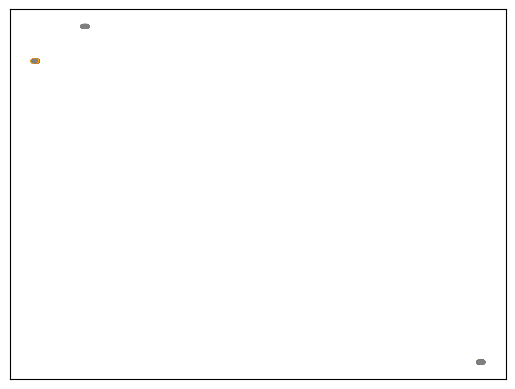

In [21]:
for name, (lat, lon) in data_points:
    print(f"### {name} ###")
    out = graphGenerator(lat, lon, 500, 5, yaml_paths,
                         f"osm_dataset/raw/{name}.osm", maps)
    print("\n\n")

In [26]:
out.nodes

,idx,building,general,color,x,y,geometry,general0,general1,general2,general3,general4
osmid,,,,,,,,,,,,
2,2,street,street,gray,688169.449778,3.986816e+06,POINT (688169.450 3986815.544),0.0,0.0,0.0,1.0,0.0
3,3,street,street,gray,688165.103413,3.986759e+06,POINT (688165.103 3986758.858),0.0,0.0,0.0,1.0,0.0
4,4,street,street,gray,688162.148663,3.986847e+06,POINT (688162.149 3986846.864),0.0,0.0,0.0,1.0,0.0
5,5,street,street,gray,688161.242164,3.986706e+06,POINT (688161.242 3986705.732),0.0,0.0,0.0,1.0,0.0
6,6,street,street,gray,688257.597251,3.986818e+06,POINT (688257.597 3986818.216),0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1159,1159,house,sleep,orange,688016.075786,3.987055e+06,POINT (688016.076 3987055.465),1.0,0.0,0.0,0.0,0.0
1160,1160,yes,street,gray,688227.677005,3.987153e+06,POINT (688227.677 3987153.428),0.0,0.0,0.0,1.0,0.0
1161,1161,roof,other,gray,688228.302631,3.987143e+06,POINT (688228.303 3987143.279),0.0,0.0,0.0,0.0,1.0


In [25]:
out.edges

u    v      osmid      highway  general  color     length  \
u    v   key                                                                 
2    3   0       2    3   16534420     tertiary      car    red  68.564899   
     4   0       2    4   16534420     tertiary      car    red  38.240955   
     6   0       2    6  353827088  residential  pedbike  green  88.271091   
     130 0       2  130  675868799      footway  pedbike  green  23.807697   
     561 0       2  561  675868738      footway  pedbike  green  43.410184   
...            ...  ...        ...          ...      ...    ...        ...   
1159 87  0    1159   87    2000518  residential  pedbike  green  27.791949   
1160 98  0    1160   98    2000519  residential  pedbike  green  33.995949   
1161 193 0    1161  193    2000520  residential  pedbike  green  34.425905   
1162 656 0    1162  656    2000521  residential  pedbike  green  30.920843   
1163 641 0    1163  641    2000522  residential  pedbike  green  53.385616   

                speed  capacity  \
u    v   key                      
2    3   0    48300.0    1100.0   
     4   0    48300.0    1100.0   
     6   0    16100.0    8000.0   
     130 0    16100.0    8000.0   
     561 0    16100.0    8000.0   
...               ...       ...   
1159 87  0    16100.0    8000.0   
1160 98  0    16100.0    8000.0   
1161 193 0    16100.0    8000.0   
1162 656 0    16100.0    8000.0   
1163 641 0    16100.0    8000.0   

                                                       geometry  general0  \
u    v   key                                                                
2    3   0    LINESTRING (688169.450 3986815.544, 688162.467...       1.0   
     4   0    LINESTRING (688169.450 3986815.544, 688162.467...       1.0   
     6   0    LINESTRING (688169.450 3986815.544, 688172.455...       0.0   
     130 0    LINESTRING (688169.450 3986815.544, 688172.519...       0.0   
     561 0    LINESTRING (688169.450 3986815.544, 688172.519...       0.0   
...                                                         ...       ...   
1159 87  0    LINESTRING (688016.076 3987055.465, 688031.759...       0.0   
1160 98  0    LINESTRING (688227.677 3987153.428, 688258.169...       0.0   
1161 193 0    LINESTRING (688228.303 3987143.279, 688257.861...       0.0   
1162 656 0    LINESTRING (688207.914 3987132.065, 688213.727...       0.0   
1163 641 0    LINESTRING (687501.189 3986416.880, 687542.834...       0.0   

              general1  general2  general3  
u    v   key                                
2    3   0         0.0       0.0       0.0  
     4   0         0.0       0.0       0.0  
     6   0         0.0       1.0       0.0  
     130 0         0.0       1.0       0.0  
     561 0         0.0       1.0       0.0  
...                ...       ...       ...  
1159 87  0         0.0       1.0       0.0  
1160 98  0         0.0       1.0       0.0  
1161 193 0         0.0       1.0       0.0  
1162 656 0         0.0       1.0       0.0  
1163 641 0         0.0       1.0       0.0  

[2346 rows x 14 columns]